# Highlighting cases when the subject smiled after an audio stimulus on the left and comparing it with a conventional audio stimulus on the left

### Working with events  
https://mne.tools/dev/auto_tutorials/raw/plot_20_event_arrays.html  

As usual we’ll start by importing the modules we need, loading some example data, and cropping the Raw object to just 60 seconds before loading it into RAM to save memory:

In [10]:
%matplotlib inline

In [1]:
import os
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw.crop(tmax=60).load_data()

<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 36038 (60.0 sec), ~107.0 MB, data loaded>

The tutorial **Parsing events from raw data** https://mne.tools/dev/auto_tutorials/intro/plot_20_events_from_raw.html#tut-events-vs-annotations describes in detail the different ways of obtaining an Events array from a Raw object (see the section Detecting experimental events for details). Since the sample dataset includes experimental events recorded on STIM channel STI 014, we’ll start this tutorial by parsing the events from that channel using mne.find_events():

In [2]:
events = mne.find_events(raw, stim_channel='STI 014')

86 events found
Event IDs: [ 1  2  3  4  5 32]


Event arrays are NumPy array objects, so they could be saved to disk as binary .npy files using numpy.save(). However, MNE-Python provides convenience functions mne.read_events() and mne.write_events() for reading and writing event arrays **as either text files** (common file extensions are .eve, .lst, and .txt) or binary .fif files. The example dataset includes the results of mne.find_events(raw) in a .fif file. Since we’ve truncated our Raw object, it will have fewer events than the events file loaded from disk (which contains events for the entire recording), but the events should match for the first 60 seconds anyway:

In [3]:
sample_data_events_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                       'sample_audvis_raw-eve.fif')
events_from_file = mne.read_events(sample_data_events_file)
assert np.array_equal(events, events_from_file[:len(events)])fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend


When writing event arrays to disk, the format will be inferred from the file extension you provide. By convention, MNE-Python expects events files to either have an .eve extension or to have a file basename ending in -eve or _eve (e.g., my_experiment_eve.fif), and will issue a warning if this convention is not respected.

# Subselecting and combining events

The output of find_events() above (repeated here) told us the number of events that were found, and the unique integer event IDs present:

In [5]:
mne.find_events(raw, stim_channel='STI 014');

86 events found
Event IDs: [ 1  2  3  4  5 32]


If some of those events are not of interest, you can easily subselect events using mne.pick_events(), which has parameters include and exclude. For example, in the sample data Event ID 32 corresponds to a subject button press, which could be excluded as:

In [6]:
events_no_button = mne.pick_events(events, exclude=32)

It is also possible to combine two Event IDs using mne.merge_events(); the following example will combine Event IDs 1, 2 and 3 into a single event labelled 1:

In [7]:
merged_events = mne.merge_events(events, [1, 2, 3], 1)
print(np.unique(merged_events[:, -1]))

[ 1  4  5 32]


Note, however, that merging events is not necessary if you simply want to pool trial types for analysis; the next section describes how MNE-Python uses event dictionaries to map integer Event IDs to more descriptive label strings.

# Mapping Event IDs to trial descriptors  

So far in this tutorial we’ve only been dealing with integer Event IDs, which were assigned based on DC voltage pulse magnitude (which is ultimately determined by the experimenter’s choices about what signals to send to the STIM channels). Keeping track of which Event ID corresponds to which experimental condition can be cumbersome, and it is often desirable to pool experimental conditions during analysis. You may recall that the mapping of integer Event IDs to meaningful descriptions for the sample dataset is given in this table in the introductory tutorial. Here we simply reproduce that mapping as an event dictionary:

In [8]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

Event dictionaries like this one are used when extracting epochs from continuous data, and the resulting Epochs object allows pooling by requesting partial trial descriptors. For example, if we wanted to pool all auditory trials, instead of merging Event IDs 1 and 2 using the merge_events() function, we can make use of the fact that the keys of event_dict contain multiple trial descriptors separated by / characters: requesting 'auditory' trials will select all epochs with Event IDs 1 and 2; requesting 'left' trials will select all epochs with Event IDs 1 and 3. An example of this is shown in a later tutorial.  

# Plotting events  
Another use of event dictionaries is when plotting events, which can serve as a useful check that your event signals were properly sent to the STIM channel(s) and that MNE-Python has successfully found them. The function mne.viz.plot_events() will plot each event versus its sample number (or, if you provide the sampling frequency, it will plot them versus time in seconds). It can also account for the offset between sample number and sample index in Neuromag systems, with the first_samp parameter. If an event dictionary is provided, it will be used to generate a legend:

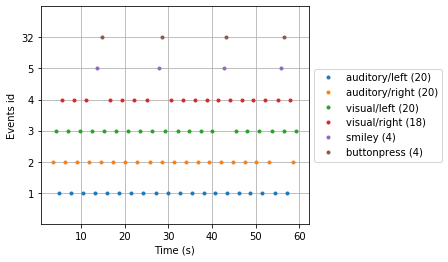

In [11]:
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict);
fig.subplots_adjust(right=0.7)  # make room for legend

# Plotting events and raw data together¶
Events can also be plotted alongside the Raw object they were extracted from, by passing the Event array as the events parameter of raw.plot:

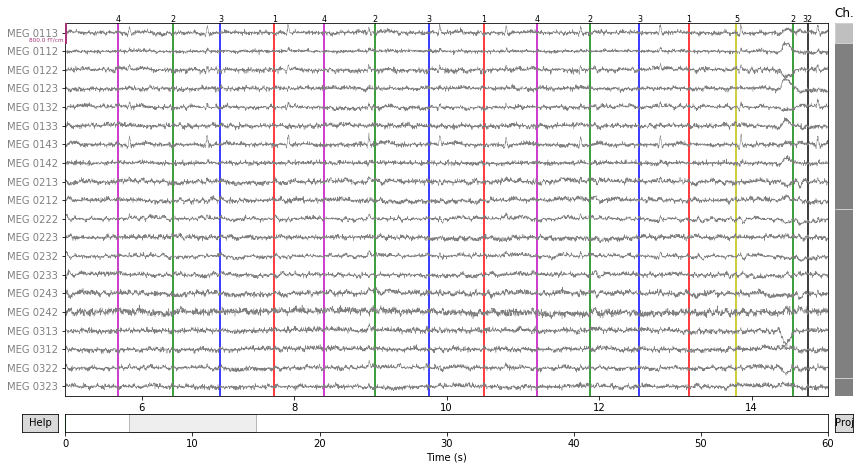

In [13]:
raw.plot(events=events, start=5, duration=10, color='gray',
         event_color={1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'y', 32: 'k'});

# Making equally-spaced Events arrays¶  
For some experiments (such as those intending to analyze resting-state activity) there may not be any experimental events included in the raw recording. In such cases, an Events array of equally-spaced events can be generated using mne.make_fixed_length_events():

In [16]:
new_events = mne.make_fixed_length_events(raw, start=5, stop=50, duration=2.)'auditory/left': 1

By default, the events will all be given the integer Event ID of 1, but you can change that with the id parameter. It is also possible to specify an overlap duration — i.e., if you ultimately want epochs that are 2.5 seconds long, but you want them to overlap by 0.5 seconds, you can specify duration=2.5, overlap=0.5 in the call to make_fixed_length_events() (this will yield the same spacing of events as duration=2, overlap=0).

# Choose auditory/left (1) event followed by a smile (5)

In [17]:
type(events)

numpy.ndarray

In [19]:
events[1]

array([28345,     0,     3])

In [20]:
id_list = events.tolist()

In [22]:
id_list[0][2]

2

In [24]:
only_id = []
for i in id_list:
    a = i[2]
    only_id.append(a)

In [43]:
smile_events[]
for id, item in enumerate(only_id):
    if item == 1 and only_id[id+1] == 5:
        smile_events.append(id)
              
smile_events

[14, 35]

In [45]:
events[[14,35]]

array([[33712,     0,     1],
       [42126,     0,     1]])

In [47]:
events[14][2] = 10
events[35][2] = 10

In [48]:
events[[14,35]]

array([[33712,     0,    10],
       [42126,     0,    10]])

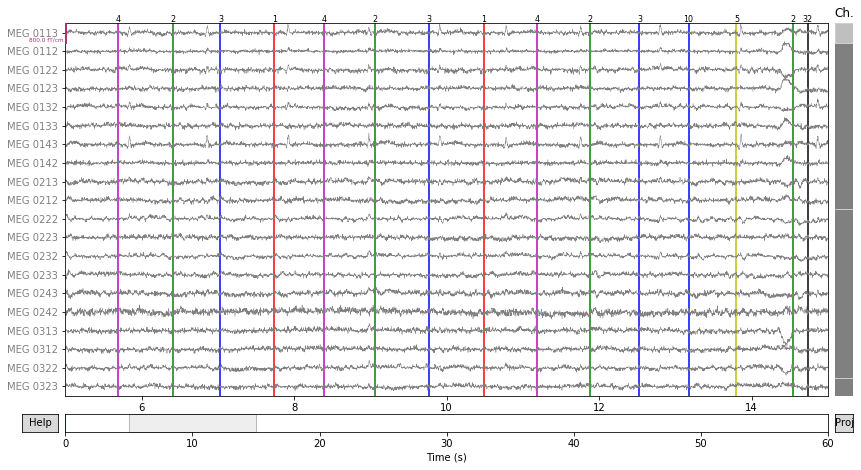

In [56]:
raw.plot(events=events, start=5, duration=10, color='gray',
         event_color={1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'y', 32: 'k', 10:'b'});

# Comparison audio/left stimuli with audio/left following by smile

In [58]:
event_id = {'auditory/left': 1, 'left/smile' :10}

In [60]:
mag_only = raw.copy().pick_types(meg='mag')
epochs = mne.Epochs(mag_only, events, event_id, tmin=-0.1, tmax=1,
                    baseline=(None, 0), preload=True)

20 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 20 events and 662 original time points ...
0 bad epochs dropped


In [62]:
conds_we_care_about = ['auditory/left', 'left/smile']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
left_epochs = epochs['auditory/left']
smile_epochs = epochs['left/smile']

Dropped 16 epochs


combining channels using "gfp"
combining channels using "gfp"


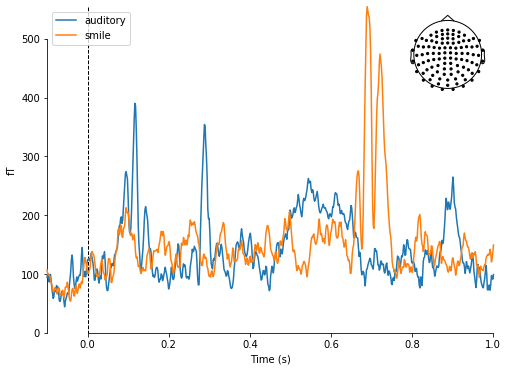

[<Figure size 576x432 with 2 Axes>]

In [63]:
left_evoked = left_epochs.average()
smile_evoked = smile_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=left_evoked, smile=smile_evoked),
                             legend='upper left', show_sensors='upper right')

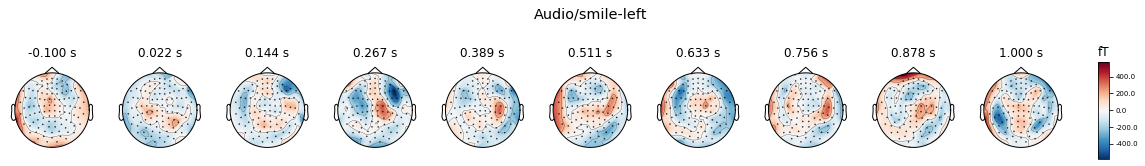

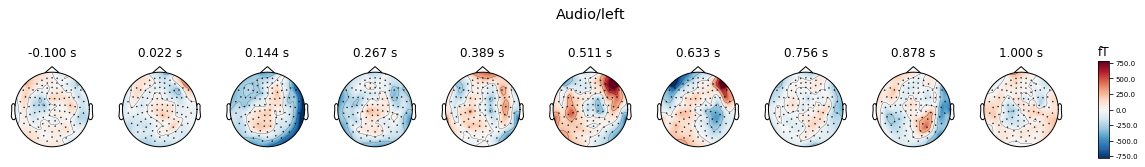

In [64]:
t = np.linspace(-0.100, 1.0, num=10)
smile_evoked.plot_topomap(times = t, title ='Audio/smile-left');
left_evoked.plot_topomap(times = t, title = 'Audio/left'); 